# Parameters

In [2]:
TRACEFILE = "./MsgTraces_W5_load-90p_0.tr"

In [3]:
from typing import Dict, List
from collections import defaultdict

class Message:
    def __init__(self, sender, receiver, txid, sz):
        self.sender = sender
        self.receiver = receiver
        self.key = self.get_key(sender, receiver, txid)

        self.sz = sz
        self.start_ts = 0.0
        self.end_ts = 0.0
    
    @property
    def completion_time(self):
        return self.end_ts - self.start_ts
    
    @staticmethod
    def get_key(sender, receiver, txid):
        return "%s %s\t%s" % (sender, receiver, txid)
    
    def __str__(self):
        return f"{self.key}\t{self.completion_time}"

messages: Dict[str, List[Message]] = defaultdict(lambda: []) 
messages_size2delays: Dict[int, List[float]] = defaultdict(lambda: []) 
messages_allsizes: List[int] = []

with open(TRACEFILE, "r") as f:
    for line in f:
        log = line.split()
        ts = float(log[1]) * 1e-9   # seconds
        sz = int(log[2])            # bytes
        sender = log[3]             # ip:port
        receiver = log[4]             # ip:port
        txid = int(log[5])

        key = Message.get_key(sender, receiver, txid)

        if log[0] == "+":
            msg = Message(sender, receiver, txid, sz)
            msg.start_ts = ts
            messages[key].append(msg)
        elif log[0] == "-":
            msg = next((m for m in messages[key] if m.end_ts == 0), None)
            if not msg:
                print("ERROR: cannot find start entry for ", line)
                continue
            
            if msg.end_ts:
                print("Message already has an end_ts!", msg)
                continue
            
            msg.end_ts = ts
            messages_allsizes.append(msg.sz)
            messages_size2delays[msg.sz].append(msg.completion_time)

all_messages_list = []
for msgs in list(messages.values()):
    all_messages_list.extend(msgs)

In [16]:
# for msg in all_messages_list:
#     print(msg)

In [5]:

import numpy as np
from scipy import stats

messages_allsizes = np.array(messages_allsizes)
msg_size_percentiles = stats.rankdata(messages_allsizes, "max")/len(messages_allsizes) * 100


In [6]:
# some basic statistics

print("Total number of messages:", len(all_messages_list))
print("Total number of distinct message sizes:", len(messages_size2delays))

num_incomplete = len([msg for msg in all_messages_list if msg.end_ts == 0])
print("Number of incomplete messages: %s" % num_incomplete)

# sorted_sizes = sorted(messages_size2delays.keys())
# for i, sz in enumerate(sorted_sizes):
#     if i == 0:
#         print(sz)
#     else:
#         print(f"{sz} +{sz - sorted_sizes[i - 1]}")


Total number of messages: 589
Total number of distinct message sizes: 212
Number of incomplete messages: 0


In [7]:
import matplotlib.pyplot as plt


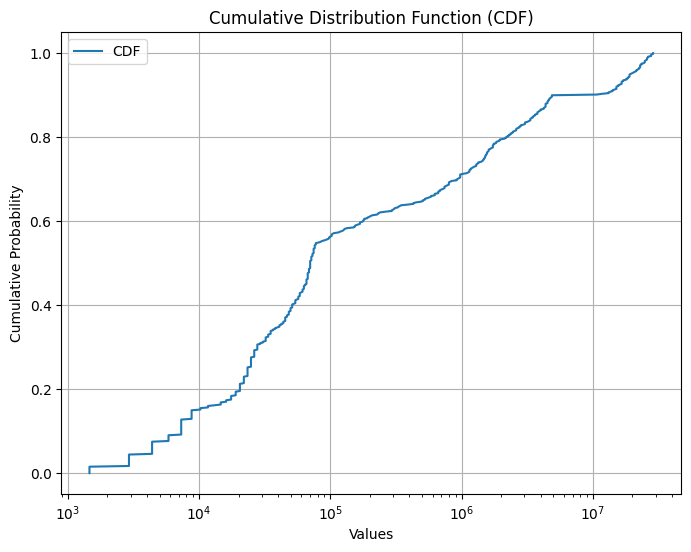

In [8]:
# basic CDF of message sizes

# Sorting the data
sorted_data = np.sort(messages_allsizes)

# Calculating the cumulative distribution
cdf = np.linspace(0, 1, len(sorted_data))

# Plotting the CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_data, cdf, label='CDF')

plt.xscale("log")

# Set labels and title
plt.xlabel('Values')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function (CDF)')

# Show legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## Average receiver bandwith utilization

In [23]:
# get total time in seconds
timespan = all_messages_list[-1].end_ts - all_messages_list[0].start_ts
# link speed in bits/s
bitrate = 10e9
max_bytes = bitrate / 8 * timespan
print(max_bytes)
# make a dict of receivers and sum of bytes received
rx_util = dict()
for msg in all_messages_list:
    if msg.receiver in rx_util:
        rx_util[msg.receiver] += msg.sz
    else:
        rx_util[msg.receiver] = msg.sz

for k in rx_util.keys():
    rx_util[k] /= max_bytes

print(rx_util.values())

12519582.50000018
dict_values([28545920, 8173080, 37475280, 1763680, 22882580, 19607800, 65700, 2376880, 36089740, 204400, 26995400, 8184760, 27494720, 1103760, 3124400, 27782340, 6483860, 5898400, 2683480, 7497100, 340180, 1043900, 1651260, 8232940, 17252820, 4095300, 24224320, 4661780, 131400, 32026560, 1480440, 217540, 27837820, 44654100, 68620, 6080900, 106580, 26517980, 2798820, 53633100, 6602120, 5164020, 19667660, 31655720, 2912700, 129940, 1933040, 3204700, 3309820, 216080, 667220, 15268680, 1724260, 71540, 15689160, 3435380, 30281860, 1797260, 52427140, 75920, 1887780, 3150680, 4847200, 91980, 19888120, 30716940, 22485460, 128480, 15747560, 20041420, 23171660, 976740, 4172680, 2962340, 4829680, 14779580, 52032940, 6679500, 21513100, 870160, 10097360, 2998840, 30660, 2771080, 5038460, 20533440, 817600, 22453340, 449680, 991340, 9457880, 6981720, 3108340, 18504040, 1153400, 8897240, 329960, 17520, 2007500, 21900, 25323700, 1071640, 2782760, 4634040, 144540, 11198200, 4813620, 22